In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [2]:
folder=r'\shrink_img'

LEARNING_RATE = 0.0001
BATCH = 100
EPOCH = 30
DROPOUT = 0.3
LAMBDA = 0.05

In [3]:
def get_path(folder):
    path = []
    for filename in sorted(os.listdir(folder)):
        name = os.path.join(folder, filename)
        path.append(name)
    return path

In [4]:
def get_label(data_pathes):
    labels = []
    for data_path in data_pathes:
        name = data_path[len(folder)+1:len(folder)+7]
#         print(name)
        lab=[]
        for j in range(len(name)):
            if 65 <= ord(name[j]) <= 90 :
                lab.append(int(ord(name[j])-55))
            else :
                lab.append(int(name[j]))
        labels.append(lab)
    return np.array(labels)

In [5]:
def img2array(datas):
    all_array = []
    for data in datas:
        img = Image.open(data)
        img = img.convert('L')
        img = np.array(img)
        
        a = 1.3
        img = img * float(a)
        img[img > 255] = 255
        img = np.round(img,3)
        img = img.astype(np.uint8)
        
        img = img/255.0
        all_array.append(img)
    return np.array(all_array)

In [6]:
# def shrink_img(all_img):
#     ShrinkImg=[]
#     for i in range(len(all_img[:])):
#         new_img=[]
#         for row in range(len(all_img[i][:])):
#             if len(all_img[i][:])/4 < row < len(all_img[i][:])*3/4:
#                 img_col=[]
#                 for col in range(len(all_img[i][row][:])):
#                     if len(all_img[i][row][:])/3 < col < len(all_img[i][row][:])*2/3:
#                         img_col.append(all_img[i][row][col])
#                 new_img.append(img_col)
#         ShrinkImg.append(new_img)
#     return np.array(ShrinkImg)

[35 11  9  2  8  1]
(14648, 191, 255, 1)


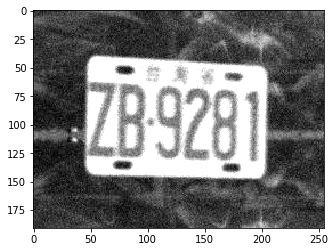

In [8]:
all_DataPath = get_path(folder)
random.shuffle(all_DataPath)
all_label = get_label(all_DataPath) 
print(all_label[0])

image = img2array(all_DataPath)    #(NUM_DATA, 191, 255)
plt.imshow(image[0], cmap='gray')

image = image[ :, :, :, np.newaxis]
print(image.shape)    #(NUM_DATA, 191, 255, 1)

In [9]:
X = tf.placeholder(tf.float32, [None, image.shape[1], image.shape[2], image.shape[3]])
Y0 = tf.placeholder(tf.float32, [None])
Y1 = tf.placeholder(tf.float32, [None])
Y2 = tf.placeholder(tf.float32, [None])
Y3 = tf.placeholder(tf.float32, [None])
Y4 = tf.placeholder(tf.float32, [None])
Y5 = tf.placeholder(tf.float32, [None])
drop = tf.placeholder(tf.float32)
lamb = tf.placeholder(tf.float32)

In [10]:
def next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [11]:
def split_label(labels):
    split_label0 = [label[0] for label in labels]
    split_label1 = [label[1] for label in labels]
    split_label2 = [label[2] for label in labels]
    split_label3 = [label[3] for label in labels]
    split_label4 = [label[4] for label in labels]
    split_label5 = [label[5] for label in labels]
    return split_label0, split_label1, split_label2, split_label3, split_label4, split_label5

In [12]:
def conv2d(input_, W, b, name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        x = tf.nn.conv2d(input_, W, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def flatten(layer):
    with tf.variable_scope('Flatten_layer'):
        num_features = layer.shape[1:].num_elements()
        flat = tf.reshape(layer, [-1, num_features])
    return flat

def get_weight_bias(weight_size):
    weight = tf.Variable(tf.random_normal(weight_size))
    bias = tf.Variable(tf.random_normal([weight_size[-1]]))
#     reg_weight = tf.multiply(tf.nn.l2_loss(weight), L, name='weight_loss')
#     tf.add_to_collection('losses', reg_weight)
    return weight, bias

def network_conv(x):
    with tf.variable_scope('conv_net'):
        W1, b1 = get_weight_bias([3, 3, 1, 64])
        W2, b2 = get_weight_bias([3, 3, 64, 128])

        l2_regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
#         l2_regularization = tf.contrib.layers.l2_regularizer(lambd)(W1)+tf.contrib.layers.l2_regularizer(lambd)(W2)
#         l1_regularization = tf.contrib.layers.l1_regularizer(lambd)(W1) + tf.contrib.layers.l1_regularizer(lambd)(W2)
        
        x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='pool1')
        
#         tf.layers.batch_normalization(x, momentum=0.999, center=True, scale=True, training=None, epsilon=0.001)
        
        x = conv2d(x, W1, b1, name='conv1')
        x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='pool2')
        
        x = conv2d(x, W2, b2, name='conv2')
        x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='pool3')
        
        x = tf.nn.dropout(x, drop)
        
        x = flatten(x)
        x0 = tf.layers.dense(x, units=36)
        x1 = tf.layers.dense(x, units=36)
        x2 = tf.layers.dense(x, units=36)
        x3 = tf.layers.dense(x, units=36)
        x4 = tf.layers.dense(x, units=36)
        x5 = tf.layers.dense(x, units=36)
        
    return l2_regularization, x0, x1, x2, x3, x4, x5

In [13]:
l2, label0, label1, label2, label3, label4, label5 = network_conv(X)

OneHot_label0 = tf.one_hot(indices=tf.cast(Y0, tf.int32), depth=36)
OneHot_label1 = tf.one_hot(indices=tf.cast(Y1, tf.int32), depth=36)
OneHot_label2 = tf.one_hot(indices=tf.cast(Y2, tf.int32), depth=36)
OneHot_label3 = tf.one_hot(indices=tf.cast(Y3, tf.int32), depth=36)
OneHot_label4 = tf.one_hot(indices=tf.cast(Y4, tf.int32), depth=36)
OneHot_label5 = tf.one_hot(indices=tf.cast(Y5, tf.int32), depth=36)

In [14]:
loss0 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label0, logits=label0))
loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label1, logits=label1))
loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label2, logits=label2))
loss3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label3, logits=label3))
loss4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label4, logits=label4))
loss5 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=OneHot_label5, logits=label5))

mean_loss = (loss0+loss1+loss2+loss3+loss4+loss5)/6.0
# tf.add_to_collection('losses', mean_loss)
# total_loss = tf.add_n(tf.get_collection('losses'))
total_loss = mean_loss + lamb*l2

In [15]:
pred0 = tf.nn.softmax(label0)
pred1 = tf.nn.softmax(label1)
pred2 = tf.nn.softmax(label2)
pred3 = tf.nn.softmax(label3)
pred4 = tf.nn.softmax(label4)
pred5 = tf.nn.softmax(label5)

correct_pred0 = tf.equal(tf.argmax(OneHot_label0, 1), tf.argmax(pred0, 1))
correct_pred1 = tf.equal(tf.argmax(OneHot_label1, 1), tf.argmax(pred1, 1))
correct_pred2 = tf.equal(tf.argmax(OneHot_label2, 1), tf.argmax(pred2, 1))
correct_pred3 = tf.equal(tf.argmax(OneHot_label3, 1), tf.argmax(pred3, 1))
correct_pred4 = tf.equal(tf.argmax(OneHot_label4, 1), tf.argmax(pred4, 1))
correct_pred5 = tf.equal(tf.argmax(OneHot_label5, 1), tf.argmax(pred5, 1))

acc_y0 = tf.reduce_mean(tf.cast(correct_pred0, tf.float32))
acc_y1 = tf.reduce_mean(tf.cast(correct_pred1, tf.float32))
acc_y2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))
acc_y3 = tf.reduce_mean(tf.cast(correct_pred3, tf.float32))
acc_y4 = tf.reduce_mean(tf.cast(correct_pred4, tf.float32))
acc_y5 = tf.reduce_mean(tf.cast(correct_pred5, tf.float32))

In [16]:
train_op = tf.train.RMSPropOptimizer(LEARNING_RATE).minimize(total_loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
x_train, x_test = image[:11500], image[11500:]
y_train, y_test = all_label[:11500], all_label[11500:]

train_iteration = int(len(y_train) / BATCH)
test_iteration = int(len(y_test) / BATCH)

In [18]:
def randomize(x, y):
    permutation = np.random.permutation(y.shape[0])
    permutation_x = x[permutation, :]
    permutation_y = y[permutation]
    return permutation_x, permutation_y

In [33]:
for epoch in range(EPOCH):
    x_train, y_train = randomize(x_train, y_train)
    print('Epoch: {}'.format(epoch + 1))
    for iteration in range(train_iteration):
        start = iteration*BATCH
        end = BATCH*(1+iteration)
        x_batch, y_batch = next_batch(x_train, y_train, start, end)
        y0_batch, y1_batch, y2_batch, y3_batch, y4_batch, y5_batch = split_label(y_batch)
        sess.run(train_op,feed_dict={X:x_batch, Y0:y0_batch, Y1:y1_batch, Y2:y2_batch, Y3:y3_batch, Y4:y4_batch, Y5:y5_batch, 
                                     drop:DROPOUT, lamb:LAMBDA})
        if (iteration+1) % 23 == 0:
            loss, acc0, acc1, acc2, acc3, acc4, acc5 = sess.run([total_loss, acc_y0, acc_y1, acc_y2, acc_y3, acc_y4, acc_y5], 
                                                                feed_dict={X:x_batch, Y0:y0_batch, Y1:y1_batch, Y2:y2_batch, 
                                                                           Y3:y3_batch, Y4:y4_batch, Y5:y5_batch, 
                                                                           drop:DROPOUT, lamb:LAMBDA})
            print('Iteration: {:2d}/{}\t loss: {:.3f}\t Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'
                  .format(iteration+1, train_iteration, loss, acc0, acc1, acc2, acc3, acc4, acc5))
    
    test_loss, test_acc0, test_acc1, test_acc2, test_acc3, test_acc4, test_acc5 = [], [], [], [], [], [], []
    for iteration in range(test_iteration):
        start = iteration*BATCH
        end = BATCH*(1+iteration)
        x_batch, y_batch = next_batch(x_test, y_test, start, end)
        y0_batch, y1_batch, y2_batch, y3_batch, y4_batch, y5_batch = split_label(y_batch)
        loss, acc0, acc1, acc2, acc3, acc4, acc5 = sess.run([total_loss, acc_y0, acc_y1, acc_y2, acc_y3, acc_y4, acc_y5], 
                                                            feed_dict={X:x_batch, Y0:y0_batch, Y1:y1_batch, Y2:y2_batch, 
                                                                       Y3:y3_batch, Y4:y4_batch, Y5:y5_batch, drop:1, lamb:0})
        test_loss.append(loss)
        test_acc0.append(acc0)
        test_acc1.append(acc1)
        test_acc2.append(acc2)
        test_acc3.append(acc3)
        test_acc4.append(acc4)
        test_acc5.append(acc5)

    avg_loss = np.mean(test_loss)
    avg_acc0 = np.mean(test_acc0)
    avg_acc1 = np.mean(test_acc1)
    avg_acc2 = np.mean(test_acc2)
    avg_acc3 = np.mean(test_acc3)
    avg_acc4 = np.mean(test_acc4)
    avg_acc5 = np.mean(test_acc5)
    print('test_loss: {:.3f}\t Test Accuracy: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}\n'
          .format(avg_loss, avg_acc0, avg_acc1, avg_acc2, avg_acc3, avg_acc4, avg_acc5))


Epoch: 1
Iteration: 23/115	 loss: 1.143	 Accuracy: 0.97, 0.89, 0.95, 0.95, 0.95, 0.98
Iteration: 46/115	 loss: 1.130	 Accuracy: 0.96, 0.92, 0.92, 0.98, 0.98, 0.97
Iteration: 69/115	 loss: 1.339	 Accuracy: 0.96, 0.91, 0.91, 0.92, 0.95, 0.96
Iteration: 92/115	 loss: 1.180	 Accuracy: 0.95, 0.91, 0.93, 0.94, 0.99, 1.00
Iteration: 115/115	 loss: 1.110	 Accuracy: 0.97, 0.98, 0.93, 0.94, 0.97, 0.96
test_loss: 3.514	 Test Accuracy: 0.11, 0.23, 0.51, 0.54, 0.16, 0.11

Epoch: 2
Iteration: 23/115	 loss: 1.198	 Accuracy: 0.93, 0.81, 0.92, 0.96, 0.94, 0.93
Iteration: 46/115	 loss: 1.183	 Accuracy: 0.97, 0.97, 0.89, 0.96, 0.94, 0.96
Iteration: 69/115	 loss: 1.154	 Accuracy: 0.99, 0.92, 0.91, 0.95, 0.94, 0.98
Iteration: 92/115	 loss: 1.163	 Accuracy: 0.95, 0.91, 0.97, 0.94, 0.94, 0.93
Iteration: 115/115	 loss: 1.096	 Accuracy: 0.93, 0.95, 0.97, 0.96, 0.96, 0.96
test_loss: 3.527	 Test Accuracy: 0.11, 0.24, 0.50, 0.53, 0.15, 0.11

Epoch: 3
Iteration: 23/115	 loss: 1.140	 Accuracy: 0.91, 0.93, 0.95, 0.9

Iteration: 115/115	 loss: 1.168	 Accuracy: 0.96, 0.92, 0.90, 0.91, 0.97, 0.96
test_loss: 3.189	 Test Accuracy: 0.10, 0.23, 0.51, 0.54, 0.16, 0.11

Epoch: 19
Iteration: 23/115	 loss: 1.087	 Accuracy: 0.95, 0.92, 0.97, 0.89, 0.91, 0.97
Iteration: 46/115	 loss: 1.102	 Accuracy: 0.98, 0.85, 0.93, 0.93, 0.96, 0.98
Iteration: 69/115	 loss: 1.027	 Accuracy: 0.97, 0.92, 0.94, 0.94, 0.98, 0.96
Iteration: 92/115	 loss: 1.084	 Accuracy: 0.95, 0.93, 0.91, 0.96, 0.95, 0.98
Iteration: 115/115	 loss: 1.039	 Accuracy: 0.98, 0.95, 0.95, 0.95, 0.98, 0.96
test_loss: 3.527	 Test Accuracy: 0.11, 0.23, 0.51, 0.52, 0.15, 0.10

Epoch: 20
Iteration: 23/115	 loss: 1.058	 Accuracy: 0.95, 0.83, 0.95, 0.97, 0.95, 0.99
Iteration: 46/115	 loss: 1.101	 Accuracy: 0.93, 0.87, 0.93, 0.98, 0.96, 0.94
Iteration: 69/115	 loss: 1.097	 Accuracy: 0.99, 0.93, 0.94, 0.93, 0.97, 0.96
Iteration: 92/115	 loss: 1.108	 Accuracy: 0.99, 0.91, 0.97, 0.95, 0.97, 0.94
Iteration: 115/115	 loss: 1.089	 Accuracy: 0.96, 0.93, 0.91, 0.97, 0.9

In [58]:
def OneHot2Str(onehots):
    Str=[]
    for onehot in onehots:
        if 0<=onehot<=9:
            Str.append(str(onehot))
        elif 10<=onehot<=36:
            Str.append(chr(onehot-10+65))
    return Str

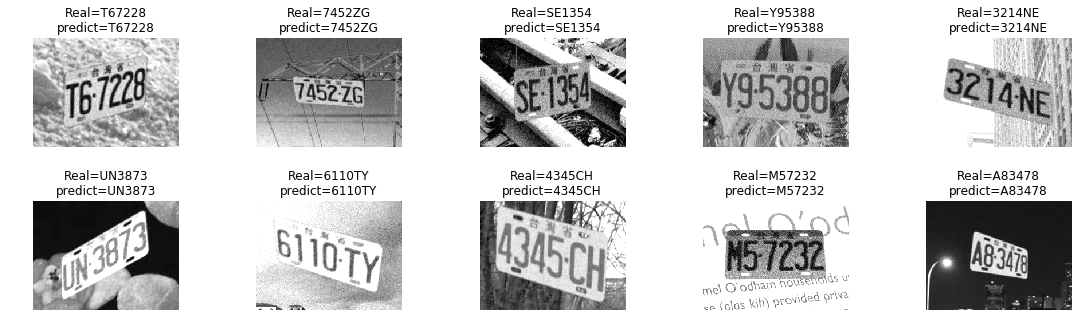

In [63]:
x_train, y_train = randomize(x_train, y_train)
x_batch, y_batch = next_batch(x_train, y_train, 0, 10)

pred0, pred1, pred2, pred3, pred4, pred5 = sess.run([label0, label1, label2, label3, label4, label5], 
                                                    feed_dict={X: x_batch, drop:1})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)
pred4 = np.argmax(pred4, axis=1)
pred5 = np.argmax(pred5, axis=1)

pred0 = OneHot2Str(pred0)
pred1 = OneHot2Str(pred1)
pred2 = OneHot2Str(pred2)
pred3 = OneHot2Str(pred3)
pred4 = OneHot2Str(pred4)
pred5 = OneHot2Str(pred5)

fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace =0, hspace =0.5)
x_batch = x_batch.reshape(10,191,255)
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(x_batch[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    title_real = y_batch[i]
    title_predict = pred0[i] + pred1[i] + pred2[i] + pred3[i] + pred4[i] + pred5[i]
    
    reals=[]
    reals.append(OneHot2Str(title_real))

    real=''.join(reals[0])
    pred=''.join(title_predict)
    title = 'Real=' + real + '\n' + 'predict=' + pred
    
    title = 'Real=' + real + '\n' + 'predict=' + pred
    
    # 如果預測錯誤，將顯示不相等
    if real != pred:
        title += '\n' + 'Not equal'
    ax.set_title(title)

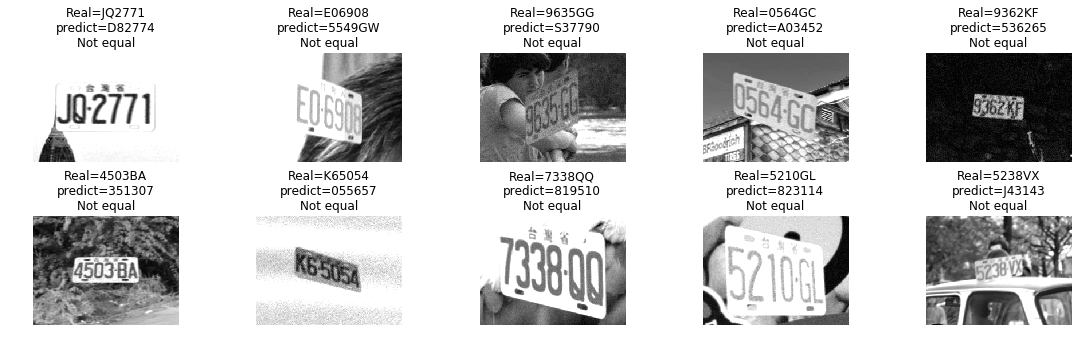

In [79]:
x_test, y_test = randomize(x_test, y_test)
x_batch, y_batch = next_batch(x_test, y_test, 0, 10)

pred0, pred1, pred2, pred3, pred4, pred5 = sess.run([label0, label1, label2, label3, label4, label5], feed_dict={X: x_batch, drop:1})

pred0 = np.argmax(pred0, axis=1)
pred1 = np.argmax(pred1, axis=1)
pred2 = np.argmax(pred2, axis=1)
pred3 = np.argmax(pred3, axis=1)
pred4 = np.argmax(pred4, axis=1)
pred5 = np.argmax(pred5, axis=1)

pred0 = OneHot2Str(pred0)
pred1 = OneHot2Str(pred1)
pred2 = OneHot2Str(pred2)
pred3 = OneHot2Str(pred3)
pred4 = OneHot2Str(pred4)
pred5 = OneHot2Str(pred5)

fig = plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace =0, hspace =0.5)
x_batch = x_batch.reshape(10,191,255)
for i in range(10):
    # 顯示圖片
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(x_batch[i], cmap='gray')
    ax.axis('off')
    
    # 處理標籤
    title_real = y_batch[i]
    title_predict = pred0[i] + pred1[i] + pred2[i] + pred3[i] + pred4[i] + pred5[i]
    
    reals=[]
    reals.append(OneHot2Str(title_real))

    real=''.join(reals[0])
    pred=''.join(title_predict)
    title = 'Real=' + real + '\n' + 'predict=' + pred
    
    title = 'Real=' + real + '\n' + 'predict=' + pred
    
    # 如果預測錯誤，將顯示不相等
    if real != pred:
        title += '\n' + 'Not equal'
    ax.set_title(title)